## Transfer Learning with MobileNet 

#### We will customise MobileNet, a lighweight, pretrained CNN for general image recognition, and use it for the most essential classification problem that ever existed - `dogs vs cats!`

---

#### Objectives:
* Test Mobilenet first
* Prepare some new dataset of images
* Create a shaved mobilenet, missing output layers
* Add our new layers 
* Freeze the training so it trains the new layers only
* wrap this into a new model class
* train and test our new model
* when we're happy, save the architecture (json) and the weights (h5)

---

### Imports

In [1]:
pip install pandas


  Using cached pandas-1.0.3-cp37-cp37m-win_amd64.whl (8.7 MB)


In [5]:
pip install opencv-python

  Using cached opencv_python-4.2.0.34-cp37-cp37m-win_amd64.whl (33.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet, imagenet_utils
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Activation
#from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
#import tqdm

#### Reset the session when you wish to reinitialise a different architecture

In [2]:
K.clear_session()
keras.__version__

'2.2.4-tf'

#### Instantiate Mobilenet

In [8]:
mobile = MobileNet()

17227776/17225924 [==============================] - 2s 0us/step


#### Prepare an image for MobileNet
* read into an array
* ensure the shape is correct
* for both steps, we can use a mixture of `opencv` and `numpy`

In [3]:
def process_for_mobilenet(file):
    image = cv2.imread(file)
    image = cv2.resize(image, dsize=(224,224),interpolation=cv2.INTER_CUBIC)
    image = preprocess_input(image)
    return image

#### We're going to add a dimension so that mobilenet accepts it

In [4]:
horse = process_for_mobilenet('horse.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


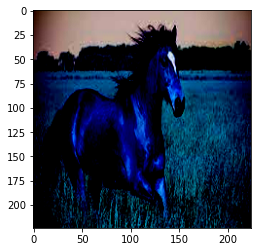

In [5]:
plt.imshow(horse)

#### Test Mobilenet on the image to test it works

In [6]:
print(horse.shape)
horse= np.expand_dims(horse, axis=0)
horse.shape

(224, 224, 3)


(1, 224, 224, 3)

In [9]:
predictions=mobile.predict(horse)

In [10]:
results = imagenet_utils.decode_predictions(predictions)
results

40960/35363 [==================================] - 0s 1us/step


[[('n02389026', 'sorrel', 0.92808676),
  ('n02403003', 'ox', 0.02502104),
  ('n02091831', 'Saluki', 0.017591495),
  ('n02090622', 'borzoi', 0.00767016),
  ('n02422106', 'hartebeest', 0.004162096)]]

In [11]:
predictions

array([[3.12109842e-06, 1.91383087e-09, 1.21718977e-05, 2.18423952e-06,
        1.07854198e-07, 9.31074646e-06, 4.92661734e-08, 2.55238916e-07,
        1.74390792e-07, 1.55625935e-06, 1.50699275e-09, 1.73924886e-09,
        3.45824147e-10, 2.07099796e-10, 8.94991992e-09, 7.01358660e-09,
        8.07567957e-10, 1.98069699e-07, 1.28131705e-09, 9.52493640e-10,
        1.00990771e-09, 6.39043947e-07, 9.71993952e-09, 2.35464859e-06,
        1.27400437e-08, 1.53886764e-10, 1.30256517e-09, 5.88171345e-10,
        7.50001092e-08, 8.51865209e-08, 1.99646788e-09, 8.42110048e-10,
        2.25831931e-09, 1.43348666e-08, 1.36109315e-06, 5.99370864e-09,
        2.59737316e-08, 1.38611261e-10, 2.36339304e-08, 2.73774344e-06,
        2.38273246e-09, 7.24412041e-09, 2.54601695e-09, 7.79052627e-08,
        7.53477725e-09, 2.30927490e-08, 6.80977896e-09, 6.53529000e-08,
        1.52783457e-08, 1.36035268e-07, 2.92762223e-08, 3.94692461e-06,
        7.30893479e-09, 2.09210160e-08, 5.58120483e-08, 5.068119

#### Now onto the real task, Transfer Learning

---

### Part 1: Chop and Customise

#### We chop when we import

In [12]:
new_mobile = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))

17227776/17225924 [==============================] - 2s 0us/step


#### And check the layers

In [13]:
new_mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [14]:
new_mobile.layers

In [16]:
len(new_mobile.layers)

87

#### Now add our own custom layers - the syntax here is different from the usual keras model creation
* First create your new_layer variable
* Then build a Keras `Model`, with inputs = the old mobilenet, and outputs = the new layers

In [18]:
new_layers = new_mobile.output
new_layers = GlobalAveragePooling2D()(new_layers)
new_layers = Dense(1024, activation='relu')(new_layers)
new_layers = Dense(512, activation='relu')(new_layers)
new_layers = Dense(512, activation='relu')(new_layers)
new_layers = Dense(2, activation='softmax')(new_layers)

In [19]:
new_mobile = Model(inputs=new_mobile.inputs, outputs=new_layers)

### 2: Freeze the layer weights that we don't want to train

In [20]:
len(new_mobile.layers)

92

In [ ]:
for i, layer in enumerate(new_mobile.layers):
    if i <87:
        layer.trainable = False
    else:
        layer.trainable = True

### 3: Prepare our images
#### First, take a look at an example

#### Now read in each image, and resize and preprocess it. We can also create our y data at the same time

In [ ]:
X = []
y = []
path = 'PATH/TO/YOUR/DATA'
train_data = os.listdir(path)

for picture in tqdm.tqdm(train_data):
    image = process_for_mobilenet(path+picture)
    X_train.append(image)
    if 'cat' in picture:
        y_train.append(0)
    elif 'dog' in picture:
        y_train.append(1) 
X = np.array(X)
y = np.array(y)

#### The overall shape of X needs to be (no.of.images, 224,224,3), and y needs to be (no.of.images,no.of_classes)
* The shape of X should already be ok (but use `np.expand_dims` if you have one pic only)
* But we can reshape y using `keras.utils.np_utils.to_categorical`

#### Finally, lets do a train/test split

### 4: Train and test!
#### Compile, fit and evaluate

---

#### Further work:
* Save the model (json) with its current weights (h5) to disk
* And load from disk

#### Save the model

In [ ]:
with open("model.json", "w") as json_file:
   json_file.write(new_mobile.to_json())
# serialize weights to HDF5
new_mobile.save_weights("model.h5")

#### Load the model

In [ ]:
from keras.models import model_from_json

# load json and create model
with open('model.json', 'r') as f:
   json = f.read()
model = model_from_json(json)

# load weights into new model
model.load_weights("model.h5")